In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Helper Functions

In [ ]:
def RemoveOutliers(df, unique, sigma=3):
    for col in df.columns:
      if df[col].nunique() > unique:
        df = df[(df[col] > (df[col].mean() - df[col].std()*sigma )) & (df[col] < (df[col].mean() + df[col].std()*sigma ))]
    return df

def preprocessing_data(df):
    df["DestType"] = [x[0] for x in df['nameDest']]
    df['nameDest'] = np.array([x[1:] for x in df['nameDest']]).astype(np.int64)
    df['nameOrig'] = np.array([x[1:] for x in df['nameOrig']]).astype(np.int64)
    return df

### Data Exploration

In [3]:
df = pd.read_csv('D:\Bank_Transaction_Analyzer\data\paysim.csv') # read the data from the CSV file

<>:1: SyntaxWarning: "\B" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\B"? A raw string is also an option.
<>:1: SyntaxWarning: "\B" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\B"? A raw string is also an option.
C:\Users\youse\AppData\Local\Temp\ipykernel_12028\1839191541.py:1: SyntaxWarning: "\B" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\B"? A raw string is also an option.
  df = pd.read_csv('D:\Bank_Transaction_Analyzer\data\paysim.csv') # read the data from the CSV file


In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
df.duplicated().sum() 

np.int64(0)

In [7]:
df.describe().round(2)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6.362620e+06,6.362620e+06,6362620.00,6362620.0
mean,243.40,179861.90,833883.10,855113.67,1.100702e+06,1.224996e+06,0.00,0.0
std,142.33,603858.23,2888242.67,2924048.50,3.399180e+06,3.674129e+06,0.04,0.0
min,1.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
25%,156.00,13389.57,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
50%,239.00,74871.94,14208.00,0.00,1.327057e+05,2.146614e+05,0.00,0.0
75%,335.00,208721.48,107315.18,144258.41,9.430367e+05,1.111909e+06,0.00,0.0
max,743.00,92445516.64,59585040.37,49585040.37,3.560159e+08,3.561793e+08,1.00,1.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [9]:
df.sample(8)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
531949,20,PAYMENT,870.09,C1562700195,139.00,0.00,M1661070361,0.00,0.00,0,0
1249466,134,CASH_IN,262826.88,C993085163,28512.00,291338.88,C1650111137,204596.75,0.00,0,0
1220352,133,CASH_OUT,170677.41,C230540290,0.00,0.00,C308972743,4882838.47,5053515.88,0,0
5622194,395,PAYMENT,8979.83,C915040452,20679.00,11699.17,M235200033,0.00,0.00,0,0
4329785,308,CASH_OUT,38100.84,C105815770,0.00,0.00,C2036515212,508726.53,546827.37,0,0
5314778,374,CASH_IN,326972.27,C164823215,12753.00,339725.27,C2093393648,0.00,0.00,0,0
1323228,137,CASH_OUT,119761.44,C1307742966,36821.73,0.00,C2117166051,4253025.78,4372787.22,0,0
5169327,358,PAYMENT,15270.24,C153901950,750534.98,735264.74,M957729579,0.00,0.00,0,0


### Data Preprocessing

In [10]:
df_cp = df.copy() 

df_cp = preprocessing_data(df_cp)

In [11]:
df_cp.sample(6)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,DestType
2238344,186,CASH_IN,106277.82,1823719524,36846.00,143123.82,1496665451,14345.42,0.00,0,0,C
2400284,202,PAYMENT,6687.03,645930037,185448.00,178760.97,1727736114,0.00,0.00,0,0,M
1948956,177,PAYMENT,6336.97,909536608,38200.44,31863.47,1798887587,0.00,0.00,0,0,M
6220135,589,CASH_OUT,95213.27,362028241,0.00,0.00,28354797,237076.43,332289.70,0,0,C
688531,36,PAYMENT,4751.88,58725031,0.00,0.00,1717054616,0.00,0.00,0,0,M
3846362,282,CASH_OUT,65356.72,1951925839,20278.00,0.00,380447495,100712.07,166068.79,0,0,C


### Data Visualization

#### Pie Plot

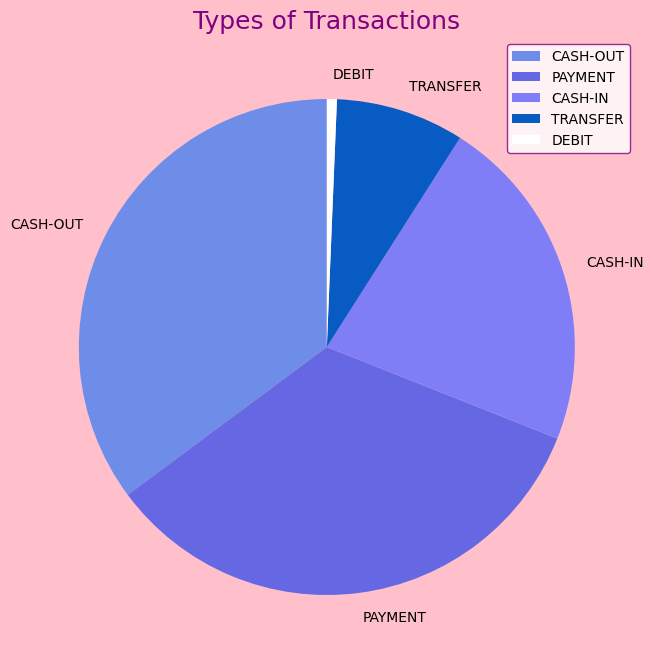

In [ ]:
fig = plt.figure()
color = ["#6e8de9", "#6668e3", "#807ef7", "#085bc2", 'white'] 
label = ['CASH-OUT', 'PAYMENT', 'CASH-IN', 'TRANSFER', 'DEBIT']
plt.pie(df_cp['type'].value_counts(), colors=color, labels=label, startangle=90)
fig.patch.set_facecolor('pink')
fig.set_size_inches(8, 9)
plt.legend(edgecolor='purple') 
plt.title('Types of Transactions', fontsize=18, color='purple') 
plt.show() 

#### Heatmap

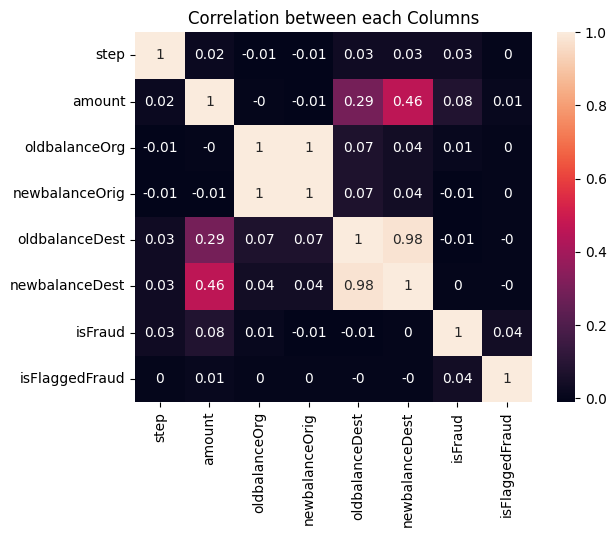

In [ ]:
sns.heatmap(df.drop(['type', 'nameDest', 'nameOrig'], axis=1).corr().round(2), annot=True) 
plt.title('Correlation between each Columns') 
plt.show()

#### Box Plot

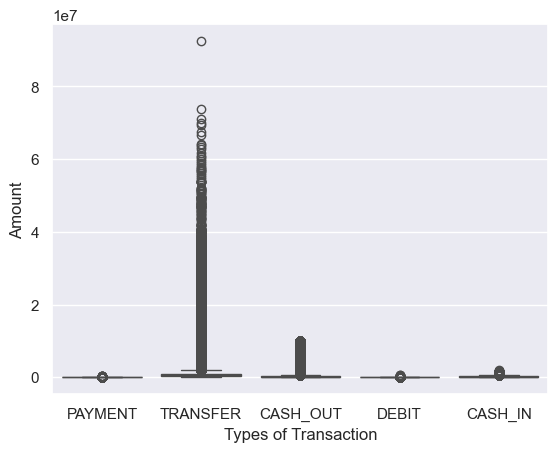

In [ ]:
sns.set(style='darkgrid')
sns.boxplot(x='type', y='amount', data=df_cp)

plt.xlabel('Types of Transaction') 
plt.ylabel('Amount') 
plt.show() 

#### Bar Plot

### Data Preparation

In [15]:
df_cp.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,DestType
0,1,PAYMENT,9839.64,1231006815,170136.0,160296.36,1979787155,0.0,0.0,0,0,M
1,1,PAYMENT,1864.28,1666544295,21249.0,19384.72,2044282225,0.0,0.0,0,0,M
2,1,TRANSFER,181.00,1305486145,181.0,0.00,553264065,0.0,0.0,1,0,C
3,1,CASH_OUT,181.00,840083671,181.0,0.00,38997010,21182.0,0.0,1,0,C
4,1,PAYMENT,11668.14,2048537720,41554.0,29885.86,1230701703,0.0,0.0,0,0,M


#### Feature Encoding

In [16]:

ohe_columns = ['type', 'DestType'] 
ohe = OneHotEncoder(sparse_output=False).fit(df_cp[ohe_columns]) 
encoded = ohe.transform(df_cp[ohe_columns])
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out()) 
df_cp = pd.concat([df_cp[[x for x in df_cp.columns if x not in ohe_columns]].reset_index(drop=True),encoded_df], axis=1)

#### Feature Scaling